In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop
from autograd import scipy as sp
import pandas as pd
import numpy
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from normflows import flows
from tqdm import tqdm_notebook as tqdm
import sys
%matplotlib inline

# Variational Inference with Normalizing Flows 
### Original Paper by : Danilo Jimenez Rezende and Shakir Mohamed
### Implemented by : Benjamin Levy and Sujay Thakur

#### Motivation
The broad idea of Variational Inference (VI) is to approximate a hard posterior $p$ (does not have an analytical form and we cannot easily sample from it) with a distribution $q$ from a family $Q$ that is easier to sample from. The choice of this $Q$ is one of the core problems in VI. Most applications employ simple families to allow for efficient inference, focusing on mean-field assumptions. This states that our approximate distribution 

$$q(z) = \prod_{i=d}^Dq(z_d)$$

i.e. factorizes completely completely over each dimension. It turns out that this restriction significantly impacts the quality of inferences made using VI, because it cannot model any correlations between dimensions. Hence, no solution of VI will ever be able to resemble the true posterior $p$ if there is any correlation present in it. In contrast, other inferential methods such as MCMC guarantee samples from the true $p$ in the asymptotic limit. We illustrate this shortcoming of mean-field VI with a simple example below.

Given a dataset $\{(x_n, y_n)\}_{n=1}^N$, assume that the outcome $y_n$ can be modeled by the following process:

\begin{aligned}
y_n &= f(x_n) + \epsilon = w_1x_n + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}

Hence, the log posterior $\log p(\textbf{w}|\mathcal{D})$ is given by:

$$\log \left[ \left(\prod_{n=1}^Np(y_n|x_n, \textbf{w})\right) p(\textbf{w}) \right] = -\frac{1}{2}\textbf{w}^T\left( \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \right)\textbf{w} + \textbf{w}^T \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right) + const.$$

Since we know this is a quadratic exponential and is Guassian, comparing with a standard multivariate Gaussian, the posterior is a bivariate Gaussian $\textbf{w} \sim \mathcal{N}(\mu_{post}, \Sigma_{post})$, where

$$\begin{aligned}
    \Sigma_{post} ^{-1} &= \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \\
    \mu_{post} &= \Sigma_{post} \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right)
\end{aligned}
$$

In this particular case, 

$$\Sigma_{post} ^{-1} = \begin{bmatrix}
    1 & 0 \\
    0 & 0.5
  \end{bmatrix}^{-1} + \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N \begin{bmatrix}
    1\\
    x_n
  \end{bmatrix} \begin{bmatrix}
    1 & x_n
  \end{bmatrix} = \begin{bmatrix}
    1+\frac{N}{\sigma_{\epsilon}^2} & \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n \\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n & 2+\frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n^2
  \end{bmatrix}$$
  
whereas the terms inside the brackets for $\mu_{post}$ are
  
$$\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} = 0 + \begin{bmatrix}
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N y_n\\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_ny_n
  \end{bmatrix}$$
  
We note that this posterior has correlation terms due to the non-zero diagonals in covariance matrix $\Sigma$. Let us now approximate this using mean-field VI.

In [2]:
#Read in the data
df = pd.read_csv('data/HW0_data.csv')
X = df['x'].values.reshape(-1,1)
y = df['y'].values.reshape(-1,1)
X_mat = sm.add_constant(X)

In [3]:
#Construct the derived posterior inverse covariance matrix from above
cov_postinv = np.zeros([2,2])
cov_postinv[0][0] = 1 + len(X)/0.5
cov_postinv[0][1] = X.sum()/0.5
cov_postinv[1][0] = X.sum()/0.5
cov_postinv[1][1] = 2 + (X**2).sum()/0.5
#Get the covariance by taking the inverse
cov_post = np.linalg.inv(cov_postinv)

#Construct the vector within the brackets for mu_post from above
vector = np.zeros([2,1])
vector[0] = y.sum()/0.5
vector[1] = (X*y).sum()/0.5
#Get the posterior mean
mu_post = np.matmul(cov_post, vector)

In [7]:
def black_box_variational_inference(logprob, D, num_samples):
    "Implements http://arxiv.org/abs/1401.0118, and uses the local reparameterization"
    "trick from http://arxiv.org/abs/1506.02557" 
    "code taken from: https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py"
    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std
    
    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        "Provides a stochastic estimate of the variational lower bound."
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound
    
    gradient = grad(variational_objective)
    
    return variational_objective, gradient, unpack_params

def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train - forward(W, x_train))**2, axis=0)
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
#     init_mean = nn.weights.flatten()
#     init_mean = np.ones(D)
    init_mean = np.array([8.81958297,5.2])
    init_log_std = -5 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])

    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)

    return variational_params

##polynomial function
def forward(w, x):
    return np.matmul(x, w.T)

In [8]:
D = 2
N = X_mat.shape[0]
sigma_e = 0.5
params = variational_inference(np.array([[1,0],[0,0.5]]),sigma_e, y, X_mat, forward, S=1000, \
                               max_iteration=1000, step_size=1e-1, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -30539.466056153142; gradient mag: 152.62214679327647
Iteration 100 lower bound -30536.363573139875; gradient mag: 4.263828645164401
Iteration 200 lower bound -30536.41529699454; gradient mag: 5.2189788551913905
Iteration 300 lower bound -30536.399523534914; gradient mag: 4.536858396887439
Iteration 400 lower bound -30536.400756914736; gradient mag: 12.99753436814084
Iteration 500 lower bound -30536.465640433682; gradient mag: 12.43011565086504
Iteration 600 lower bound -30536.41793852928; gradient mag: 25.94459523568
Iteration 700 lower bound -30536.39405035595; gradient mag: 10.57352972331591
Iteration 800 lower bound -30536.385576378372; gradient mag: 3.887746753029703
Iteration 900 lower bound -30536.468270997004; gradient mag: 1.1049825733521936


Let us plot the PDF of $p$ and the learned $q$.

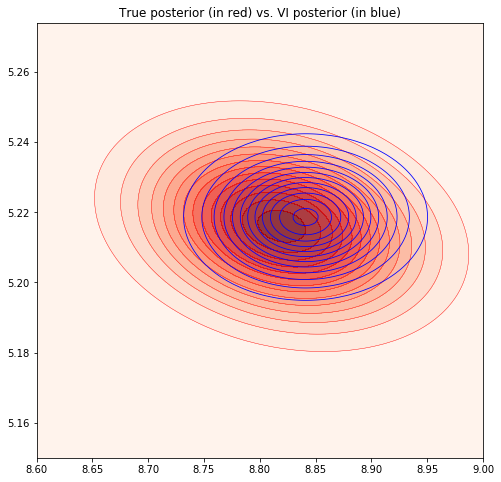

In [10]:
mu_VI = params[:D]
cov_VI = np.diag(np.exp(params[D:])**2)

x, y = numpy.mgrid[8.6:9:.001, 5.15:5.275:.001]
pos = numpy.dstack((x, y))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

z = scipy.stats.multivariate_normal(mu_post.flatten(), cov_post).pdf(pos)
z_VI = scipy.stats.multivariate_normal(mu_VI, cov_VI).pdf(pos)

ax.contourf(x, y, z, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z, levels=14, linewidths=0.4, colors='red')

ax.contour(x, y, z_VI, levels=14, linewidths=0.8, colors='blue')
plt.title('True posterior (in red) vs. VI posterior (in blue)')

plt.show()

As expected, the true posterior $p$ has a slope due to the non-zero diagonals, something which our mean-field assumed $q$ could never capture. Additionally, there are two commonly experienced problems (Turner & Sahani, 2011):

- Under-estimation of the variance of the posterior. This is observed in the above plot where our $q$ is more concentrated.
- Biases in the MAP solution of parameters. This is observed in the above plot where our learned $\mu$ for $q$ does not coincide perfectly with the true $\mu$ for $p$.

These issues mean that the subsequent decisions we make using our VI solution could be biased and have incorrect uncertainty estimates. In fields such as medical operations, these could have dire consequences.

#### Alternatives

There are a number of proposals for rich posterior approximations that have been explored, but there are some limitations :

- Structured mean-field : Instead of assuming fully factorized posteriors, this assumes that the distribution factorizes into a product of tractable distributions, such as trees or chains (Shukla, Shimazaki, & Ganguly, 2019). While this allows for the modeling of some correlations, the subsequent optimization becomes too complex for any realistic applications.
- Mixture model : This specifies the approximate posterior as a mixture model, and hence captures multi-modality well (Jordan et al., 1999). However, this limits the potential scalability of VI since it requires evaluation of the log-likelihood and its gradients for each mixture component per parameter update, which is typically computationally expensive.

#### Normalizing Flows

A normalizing flow describes the transformation of a probability density through a series of invertible mappings, making the initial simple density 'flow' through the mappings and result in a more complex distribution (Tabak & Turner, 2013). These mappings can be shown to preserve the PDF normalization property : 

$$\int_\mathbf{z}q_k(\mathbf{z}_k)d\mathbf{z}_k = 1$$

at each stage $k$ of the flow, resulting in a valid density at the end.

We will consider the simple case of Planar flows, which introduces enough complexity in the approximate posterior $q$ for many applications. This uses an invertible and smooth mapping $f:\mathbb{R}^d \rightarrow \mathbb{R}^d$. If we use this to transform a random variable $\mathbf{z} \sim q(\mathbf{z})$, the resulting $\mathbf{z}^\prime = f(\mathbf{z})$ can be shown to be distributed as : 

$$q(\mathbf{z}^\prime) = q(\mathbf{z})\left|\det\frac{\partial f^{-1}}{\partial \mathbf{z}^\prime}\right| = q(\mathbf{z})\left|\det\frac{\partial f}{\partial \mathbf{z}^\prime}\right|^{-1}$$

Now, imagine applying this process multiple times to construct arbitrarily complex distributions. After $K$ such transformations on the initial $\mathbf{z}_0$, using the above equation, the resulting random variable 

$$\mathbf{z}_K = f_K\circ\cdots\circ f_1(\mathbf{z_0})$$

has log density

$$\log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}_0) - \sum_{k=1}^K \log\left|\det\frac{\partial f_k}{\partial \mathbf{z}_{k-1}}\right|$$

This path formed by the distributions $q_1,\cdots,q_K$ is called a <em>normalizing flow</em>. Using the law of the unconscious statistician (Blitzstein & Hwang, 2014), we are able to compute expectations using the transformed density $q_k$ without explicity knowing it : 

$$\mathbb{E}_{q_k}\left[h(\mathbf{z})\right] = \mathbb{E}_{q_0}\left[h\left(f_k\circ f_{k-1}\circ\cdots\circ f_1(\mathbf{z}_0)\right)\right]$$

This is one of the major innovations for using normalizing flows for VI, since we will need to eventually compute expectations under later flow distributions $q_k, k\in\{1,\cdots K\}$. However, since it is not always possible to sample $\mathbf{z}_k \sim q_k(\mathbf{z}_k)$ if $q_k$ becomes complex enough, this equation allows us to compute such expectations using $\mathbf{z}_0 \sim q_0$ where $q_0$ would be the simple starting distribution we select, e.g. an isotropic Gaussian.

We can think of these Planar flows as a sequence of expansions and contractions on the initial density $q_0$. To visualize this process and understand how the different parameters affect the flows, we created a applet that can be accessed via ''''''. Go ahead and give it a try!

Planar flows can be expressed as : 

$$f(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^\text{T}\mathbf{z} + b)$$

where the parameters $\lambda = \{\mathbf{w}\in\mathbb{R}^D, \mathbf{u}\in\mathbb{R}^D, b\in\mathbb{R}\}$ and $h$ is a smooth non-linearity that is chosen to be $tanh$ for this flow. Note that we can write the derivative of the $h(\mathbf{w}^\text{T}\mathbf{z} + b)$ term using chain rule as :

$$\psi(\mathbf{z}) = h^\prime(\mathbf{w}^\text{T}\mathbf{z} + b)\mathbf{w}$$

Hence using the matrix determinant lemma,

$$\left|\det\frac{\partial f}{\partial \mathbf{Z}}\right| = \left|\det\left(\mathbf{I} + \mathbf{u}\psi(\mathbf{z})^\text{T}\right)\right| = \left|1 + \mathbf{u}^\text{T}\psi(\mathbf{z})\right|$$


The log density from above can thus be expressed as 

$$\log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}_0) - \sum_{k=1}^K \log\left|1 + \mathbf{u}_k^\text{T}\psi_k(\mathbf{z}_{k-1})\right|$$

which only requires an analytical distribution expression for the simple $q_0$.

#### VI with Normalizing Flows 

This paper proposes a technique to implement VI using Normalizing Flows. The main ideas from the authors are : 
 - Specify the approximate posterior using normalizing flows that allows for construction of complex distributions by transforming a density through a series of invertible mappings. This provides a tighter, modified evidence lower bound (ELBO) with additional terms that have linear time complexity. This is in contrast with the alternative methods above which require more complex optimizations.
 - It can be shown that using VI with normalizing flows specifies a class of $q$ distributions that provide asymptotic guarantees, as opposed to naive mean-field VI.
 - This method is shown to systematically outperform other competing approaches for posterior approximation.

In [43]:
sigmoid = lambda x: 1/(1+np.exp(-x))
w1 = lambda x: np.sin(2 * np.pi * x/4)
w2 = lambda x: 3*np.exp(-0.5*((x-1)/0.6)**2)
w3 = lambda x: 3*sigmoid((x-1)/0.3)

def trial1(z):
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
    else:
        z1, z2 = z[0], z[1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)        

def p1(z):
    '''Apply posterior p_1 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        first = (np.linalg.norm(z, 2, 1) - 2)/0.4
        exp1 = np.exp(-0.5*((z1 - 2)/0.6)**2)
        exp2 = np.exp(-0.5*((z1 + 2)/0.6)**2)
        u = 0.5*first**2 - np.log(exp1 + exp2)
        return np.exp(-u)
    else:
        first = (np.linalg.norm(z)-2)/0.4
        second = np.exp(-0.5*((z[0] - 2)/0.6)**2)
        third = np.exp(-0.5*((z[0] + 2)/0.6)**2)
        return np.exp(-0.5*first**2 + np.log(second+third))

def p2(z):
    '''Apply posterior p_2 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        u = 0.5 * ((z2 - w1(z1))/0.4) ** 2
        dummy = np.ones(u.shape) * 1e7
        u = np.where(np.abs(z1) <= 4, u, dummy)
        return np.exp(-u)
    else:
        first = (z[1] - w1(z[0]))/0.4
        return np.exp(-0.5*first**2)

def p3(z):
    '''Apply posterior p_3 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        exp1 = np.exp(-0.5*((z2 - w1(z1))/0.35)**2)
        exp2 = np.exp(-0.5*((z2 - w1(z1) + w2(z1))/0.35)**2)
        u = - np.log(exp1 + exp2)
        return np.exp(-u)
        
    else:
        first = np.exp(-0.5*((z[1] - w1(z[0]))/0.35)**2)
        second = np.exp(-0.5*((z[1] - w1(z[0]) + w2(z[0]))/0.35)**2)
        return first+second

def p4(z):
    '''Apply posterior p_4 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        exp1 = np.exp(-0.5*((z2 - w1(z1))/0.4)**2)
        exp2 = np.exp(-0.5*((z2 - w1(z1) + w3(z1))/0.35)**2)
        u = - np.log(exp1 + exp2)
        return np.exp(-u)
    else:
        first = np.exp(-0.5*((z[1] - w1(z[0]))/0.4)**2)
        second = np.exp(-0.5*((z[1] - w1(z[0]) + w3(z[0]))/0.35)**2)
        return first+second

In [47]:
ndim = 2
mu0 = np.zeros(ndim)
Sigma0 = np.eye(ndim)
N = 1000

samples = np.random.multivariate_normal(mu0, Sigma0, size=N)

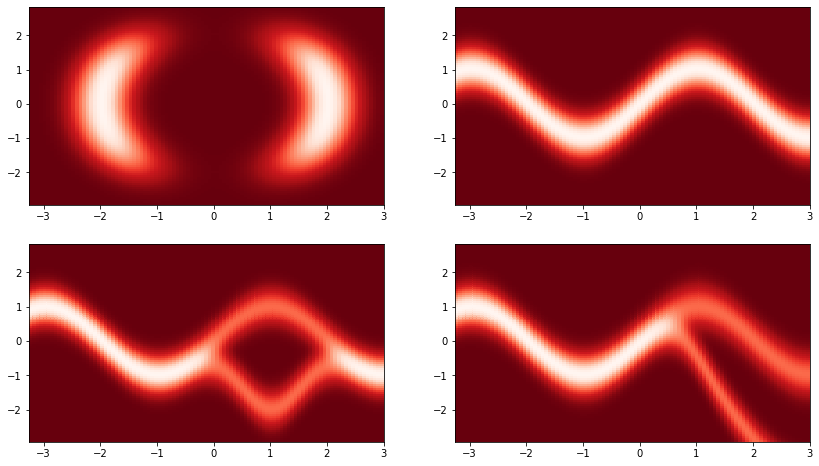

In [42]:
fig,ax=plt.subplots(2,2,figsize = (14,8))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
xi, yi = numpy.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = np.array([p1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p2(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p3(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p4(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

plt.show()

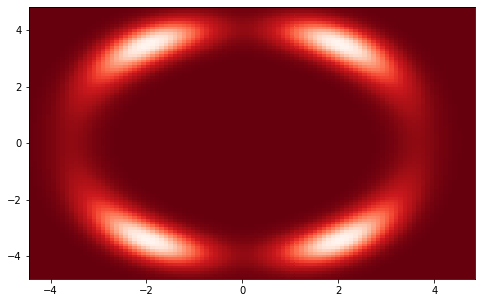

In [51]:
fig,ax=plt.subplots(1,1,figsize = (8,5))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
xi, yi = numpy.mgrid[x.min()-1.5:x.max()+1.5:nbins*1j, y.min()-1.5:y.max()+1.5:nbins*1j]

zi = np.array([trial1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
plt.show()

In [67]:
m = lambda x: -1 + np.log(1 + np.exp(x))
h = lambda x: np.tanh(x)
h_prime = lambda x: 1 - np.tanh(x)**2


def gradient_create(target, eps, dim_z, num_samples, K):

    def unpack_params(params):
        W = params[:K*dim_z].reshape(K,dim_z)
        U = params[K*dim_z:2*K*dim_z].reshape(K,dim_z)
        B = params[-K:]
        return W,U,B

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        W,U,B = unpack_params(params)
        z0 = np.random.multivariate_normal(np.zeros(dim_z), np.eye(dim_z),
                num_samples)
        z_prev = z0
        sum_log_det_jacob = 0.
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            affine = np.outer(h_prime(np.matmul(z_prev, w) + b), w)
            sum_log_det_jacob += np.log(eps + np.abs(1 + np.matmul(affine, u)))
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        #log_q_K = sp.stats.multivariate_normal.pdf(z0, np.zeros(2), np.eye(2))
        #- sum_log_det_jacob
        log_q_K = -0.5 * np.sum(np.log(2*np.pi) + z0**2, 1) - sum_log_det_jacob
        log_p = np.log(eps + target(z_K))
        return np.mean(log_q_K - log_p)

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


def callback(params, t, g):
    if t%100 == 0:
        print("Iteration {}; Gradient mag: {}; Objective: {}".format(t,
            np.linalg.norm(gradient(params, t)), objective(params, t)))
        objectives.append(objective(params, t))
    if t%5000 == 0:
        W, U, B = unpack_params(params)
        z0 = np.random.randn(num_samples, dim_z)
        z_prev = z0
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        plt.figure(figsize=(5,4))
        plt.scatter(z_K[:,0], z_K[:,1])
        plt.show()

In [73]:
def optimise(func, num_samples, num_iter, lr, K=16, dim_z=2):

    objectives = []
    objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)
    init_W = 1*np.ones((K, dim_z))
    init_U = 1*np.ones((K, dim_z))
    init_b = 1*np.ones((K))
    init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))

    variational_params = adam(gradient, init_params, callback, num_iter, lr)
    
    return variational_params

def visualise(func, variational_params, K=16, dim_z=2, xlimits=[-4,4], ylimits=[-4,4]):
    W, U, B = unpack_params(variational_params)
    z0 = np.random.randn(1000, dim_z)
    z_prev = z0
    for k in range(K):
        w, u, b = W[k], U[k], B[k]
        u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
        z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
    z_K = z_prev
              
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].plot(objectives)
              
    nbins = 100
    x, y = z0[:, 0], z0[:, 1]
    xi, yi = numpy.mgrid[-4:4:nbins*1j, -4:4:nbins*1j]
    zi = np.array([func(np.vstack([xi.flatten(), yi.flatten()])[:,i].reshape(-1,2)) for i in range(nbins**2)])
    ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape))
    ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
    ax[1].scatter(z_K[:,0], z_K[:,1], alpha=0.2)
    ax[1].set_xlim(xlimits)
    ax[1].set_ylim(ylimits)
    plt.show()

Iteration 0; Gradient mag: 5.421601657873589; Objective: 11.845848483211933


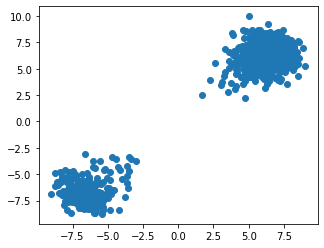

Iteration 100; Gradient mag: 42.13729254704142; Objective: 11.897037942980257
Iteration 200; Gradient mag: 0.5640743779907037; Objective: 11.822853202082975
Iteration 300; Gradient mag: 5.910535937856741; Objective: 11.820580573553315
Iteration 400; Gradient mag: 12.72949404249603; Objective: 11.842447263876625
Iteration 500; Gradient mag: 9.895050218094381; Objective: 11.710122910881276
Iteration 600; Gradient mag: 6.7375404042807325; Objective: 11.808107833594157
Iteration 700; Gradient mag: 11.723383804635978; Objective: 11.769751673657403
Iteration 800; Gradient mag: 4.88032826580765; Objective: 11.411016934341307
Iteration 900; Gradient mag: 8.469308675133652; Objective: 11.203586020651928
Iteration 1000; Gradient mag: 5.105607798680305; Objective: 10.721725016746682
Iteration 1100; Gradient mag: 7.057000595772424; Objective: 10.499389019709382
Iteration 1200; Gradient mag: 12.97546867614542; Objective: 9.132837367940125
Iteration 1300; Gradient mag: 18.7417614571286; Objective: 5

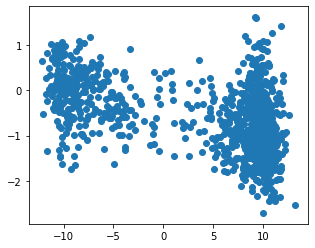

Iteration 5100; Gradient mag: 9.085135937755462; Objective: -1.7421077881640767
Iteration 5200; Gradient mag: 8.042408899138492; Objective: -2.0434150743247104
Iteration 5300; Gradient mag: 8.785240255779577; Objective: -2.5770287886801833
Iteration 5400; Gradient mag: 7.168139444132603; Objective: -2.4587940776618717
Iteration 5500; Gradient mag: 11.569099801549061; Objective: -3.105635075467483
Iteration 5600; Gradient mag: 9.870701673845376; Objective: -3.1050938962309655
Iteration 5700; Gradient mag: 7.090918048169918; Objective: -3.4232679554363687
Iteration 5800; Gradient mag: 10.636236332408158; Objective: -4.110559354110726
Iteration 5900; Gradient mag: 5.927087088653367; Objective: -4.876085163525528
Iteration 6000; Gradient mag: 6.849437612508478; Objective: -5.067914139904853
Iteration 6100; Gradient mag: 10.254468278231174; Objective: -5.625152635355518
Iteration 6200; Gradient mag: 9.853687460792187; Objective: -6.015133171485398
Iteration 6300; Gradient mag: 11.2307704119

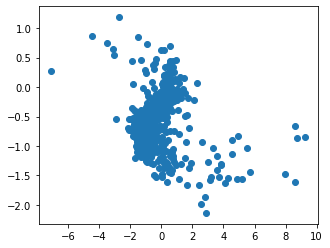

Iteration 10100; Gradient mag: 5.1683577285702; Objective: -13.639049962011379
Iteration 10200; Gradient mag: 4.644596755103202; Objective: -13.796654436689208
Iteration 10300; Gradient mag: 5.581593084953488; Objective: -13.926404390608408
Iteration 10400; Gradient mag: 4.591390736391351; Objective: -13.991321991986245
Iteration 10500; Gradient mag: 5.055377864855223; Objective: -14.090754864693011
Iteration 10600; Gradient mag: 5.226229159797602; Objective: -14.252508884064081
Iteration 10700; Gradient mag: 4.999438429355209; Objective: -14.295414834581143
Iteration 10800; Gradient mag: 5.509460040807328; Objective: -14.400839043784579
Iteration 10900; Gradient mag: 4.885167387917527; Objective: -14.497403147616623
Iteration 11000; Gradient mag: 5.276169947282823; Objective: -14.601366285279012
Iteration 11100; Gradient mag: 5.279705175640016; Objective: -14.79127839943706
Iteration 11200; Gradient mag: 4.725933629354452; Objective: -14.764912073951878
Iteration 11300; Gradient mag: 

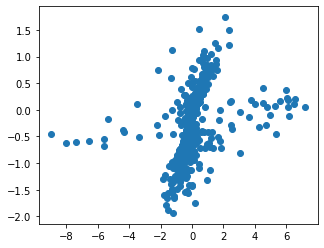

Iteration 15100; Gradient mag: 19.896368235972574; Objective: -18.356437504674904
Iteration 15200; Gradient mag: 18.228160191536627; Objective: -18.40504925394501
Iteration 15300; Gradient mag: 14.627056558741778; Objective: -18.50656774115797
Iteration 15400; Gradient mag: 21.6505685698489; Objective: -18.557673283970054
Iteration 15500; Gradient mag: 21.80217004557104; Objective: -18.551325378205213
Iteration 15600; Gradient mag: 13.854838793142724; Objective: -18.624033359172905
Iteration 15700; Gradient mag: 22.767860571552266; Objective: -18.553768037517656
Iteration 15800; Gradient mag: 19.680420178037703; Objective: -18.781371134972463
Iteration 15900; Gradient mag: 16.310253308075872; Objective: -18.820989308154086
Iteration 16000; Gradient mag: 23.639652563257563; Objective: -18.965775324034336
Iteration 16100; Gradient mag: 22.967275659988438; Objective: -18.890600809134657
Iteration 16200; Gradient mag: 37.25547097488955; Objective: -18.985008704573406
Iteration 16300; Gradi

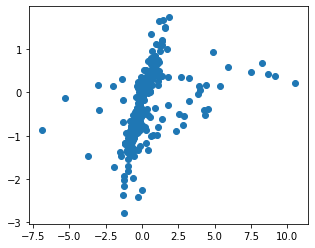

Iteration 20100; Gradient mag: 28.557833028036928; Objective: -20.834720156462396
Iteration 20200; Gradient mag: 64.36739935928496; Objective: -21.0173515814618
Iteration 20300; Gradient mag: 32.74752992781005; Objective: -21.069160565191414
Iteration 20400; Gradient mag: 69.72050260219314; Objective: -21.008880303738252
Iteration 20500; Gradient mag: 75.81874218969371; Objective: -21.09210653685731
Iteration 20600; Gradient mag: 110.21567564794624; Objective: -21.182379028627537
Iteration 20700; Gradient mag: 149.70609398406077; Objective: -21.254338670941696
Iteration 20800; Gradient mag: 115.7830489164699; Objective: -21.160059301502457
Iteration 20900; Gradient mag: 26.76518008456866; Objective: -21.274766473626062
Iteration 21000; Gradient mag: 102.74638733606623; Objective: -21.269666289079737
Iteration 21100; Gradient mag: 113.85260271152404; Objective: -21.299963291984486
Iteration 21200; Gradient mag: 73.07370899947874; Objective: -21.289576780087206
Iteration 21300; Gradient 

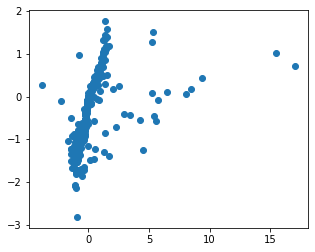

Iteration 25100; Gradient mag: 157.06547300535073; Objective: -22.324416271247596
Iteration 25200; Gradient mag: 105.83662756012964; Objective: -22.454709067815305
Iteration 25300; Gradient mag: 217.43076731085196; Objective: -22.459235320998037
Iteration 25400; Gradient mag: 7.47516158375344; Objective: -22.462444188354457
Iteration 25500; Gradient mag: 192.05310400980247; Objective: -22.41113358096246
Iteration 25600; Gradient mag: 230.65391150435494; Objective: -22.418802907285556
Iteration 25700; Gradient mag: 381.2371888781118; Objective: -22.524996307808127
Iteration 25800; Gradient mag: 533.6623686573704; Objective: -22.42424101989613
Iteration 25900; Gradient mag: 640.8986998686279; Objective: -22.397273070232178
Iteration 26000; Gradient mag: 452.2693592753129; Objective: -22.477843634509984
Iteration 26100; Gradient mag: 515.7443335935261; Objective: -22.49590281540733
Iteration 26200; Gradient mag: 364.80480158597874; Objective: -22.59204073744661
Iteration 26300; Gradient m

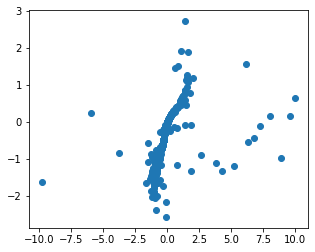

Iteration 30100; Gradient mag: 297.0252123360142; Objective: -23.227644518280627
Iteration 30200; Gradient mag: 1161.7310193008027; Objective: -23.20924641223782
Iteration 30300; Gradient mag: 900.6996332668016; Objective: -23.26744435223097
Iteration 30400; Gradient mag: 882.3009819463163; Objective: -23.20368843606573
Iteration 30500; Gradient mag: 247.29537439176133; Objective: -23.2528625870657
Iteration 30600; Gradient mag: 233.7599433669199; Objective: -23.28397178151733
Iteration 30700; Gradient mag: 720.3962101550475; Objective: -23.37095953538762
Iteration 30800; Gradient mag: 754.5718789002698; Objective: -23.323372152144657
Iteration 30900; Gradient mag: 725.1513315733798; Objective: -23.273698482856307
Iteration 31000; Gradient mag: 534.5231929994231; Objective: -23.265140486387445
Iteration 31100; Gradient mag: 479.05690059052677; Objective: -23.268056589160043
Iteration 31200; Gradient mag: 1131.0280405515284; Objective: -23.295515815859602
Iteration 31300; Gradient mag: 

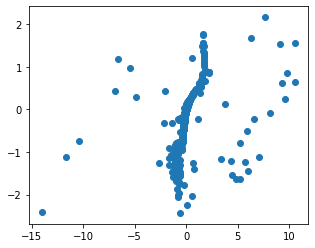

Iteration 35100; Gradient mag: 377.29590663935465; Objective: -23.684521285430176
Iteration 35200; Gradient mag: 1651.2002905130985; Objective: -23.69732848073388
Iteration 35300; Gradient mag: 1175.570812320484; Objective: -23.588730197046484
Iteration 35400; Gradient mag: 2610.1578776443016; Objective: -23.60664211181296
Iteration 35500; Gradient mag: 951.5095898869348; Objective: -23.774330719016838
Iteration 35600; Gradient mag: 674.444288573128; Objective: -23.90360708665178
Iteration 35700; Gradient mag: 862.3891577156592; Objective: -23.677287506213222
Iteration 35800; Gradient mag: 1368.5065284881323; Objective: -23.80024936050068
Iteration 35900; Gradient mag: 1305.0635488325447; Objective: -23.53783831371461
Iteration 36000; Gradient mag: 1980.0583480601567; Objective: -23.705570202648175
Iteration 36100; Gradient mag: 1936.488716786932; Objective: -23.66086860762533
Iteration 36200; Gradient mag: 3321.5947657042625; Objective: -23.704799721430128
Iteration 36300; Gradient ma

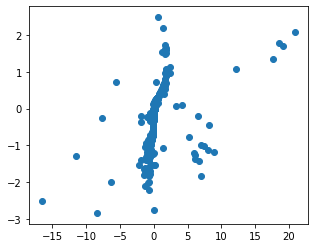

Iteration 40100; Gradient mag: 2621.9082903930143; Objective: -23.92034700741199
Iteration 40200; Gradient mag: 1628.0540114796488; Objective: -24.02509437810374
Iteration 40300; Gradient mag: 836.7580710584061; Objective: -23.826103591802646
Iteration 40400; Gradient mag: 2685.3976163682873; Objective: -24.00229161585661
Iteration 40500; Gradient mag: 1627.5701713736582; Objective: -23.97423013376833
Iteration 40600; Gradient mag: 1288.7937911441097; Objective: -24.087203031363632
Iteration 40700; Gradient mag: 2072.364624649045; Objective: -23.96178540329405
Iteration 40800; Gradient mag: 4051.7654378613624; Objective: -23.968674237499073
Iteration 40900; Gradient mag: 2646.8699006394872; Objective: -23.9128804586803
Iteration 41000; Gradient mag: 2360.7601496116113; Objective: -23.98371617005989
Iteration 41100; Gradient mag: 2109.191610370385; Objective: -24.046703809960697
Iteration 41200; Gradient mag: 3281.2994570197566; Objective: -23.89955082023915
Iteration 41300; Gradient ma

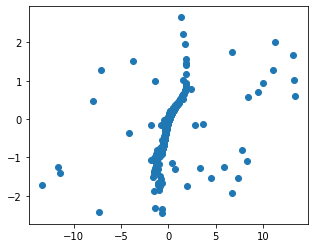

Iteration 45100; Gradient mag: 1693.2787169003213; Objective: -24.04344427317697
Iteration 45200; Gradient mag: 1683.39060367535; Objective: -24.099401342962448
Iteration 45300; Gradient mag: 4609.986235431033; Objective: -24.248713540544347
Iteration 45400; Gradient mag: 2416.581397525449; Objective: -24.079028823580707
Iteration 45500; Gradient mag: 2460.9965830751325; Objective: -23.964320449069163
Iteration 45600; Gradient mag: 2735.6524568749333; Objective: -23.995898662928937
Iteration 45700; Gradient mag: 3086.0195591331512; Objective: -24.212870841356366
Iteration 45800; Gradient mag: 2939.7579755796787; Objective: -24.145786929545416
Iteration 45900; Gradient mag: 3393.755531817813; Objective: -24.306766569116654
Iteration 46000; Gradient mag: 3884.8962286738865; Objective: -24.061068306059944
Iteration 46100; Gradient mag: 942.583632680669; Objective: -24.137220893240862
Iteration 46200; Gradient mag: 5036.503792322095; Objective: -24.186060308825553
Iteration 46300; Gradient

In [71]:
variational_params = optimise(p4, 1000, 50000, 1e-4, K=16)

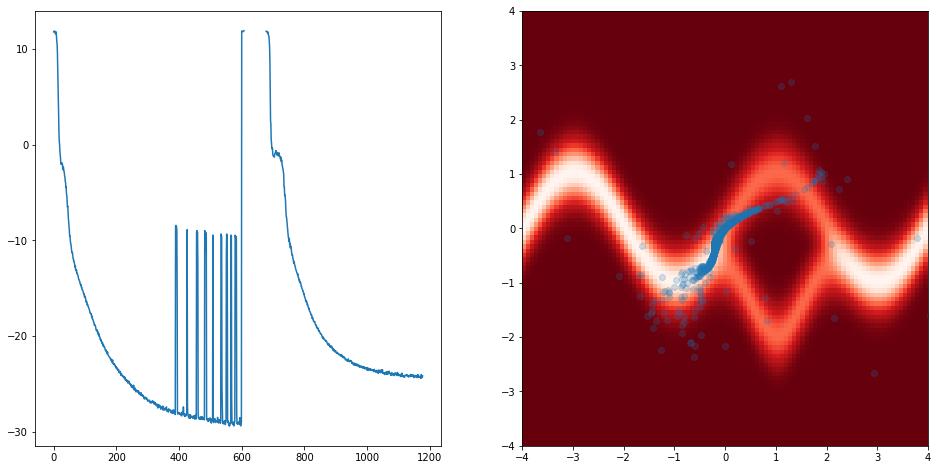

In [74]:
visualise(p3, variational_params)

1. Initialise at a mode --> collapses, eg univariate GMM or bivariate p1 bean.
2. Collapses when high K is used.

#### References
1. Turner, R. E. and Sahani, M. Two problems with variational expectation maximisation for time-series models. In Barber, D., Cemgil, T., and Chiappa, S. (eds.), <em>Bayesian Time series models</em>, chapter 5, pp. 109–130. Cambridge University Press, 2011.

2. Shukla, S., Shimazaki, H., & Ganguly, U. Structured Mean-field Variational Inference and Learning in Winner-take-all Spiking Neural Networks, 2019.

3. Tabak, E. G. and Turner, C. V. A family of nonparametric density estimation algorithms. <em>Communications on Pure and Applied Mathematics</em>, 66(2):145–164, 2013.

4. Blitzstein, J. K., & Hwang, J. Introduction to Probability (1st ed.). <em>Chapman and Hall</em>, pp. 156, 2014.